# Task 1 - CNN Model

---
## Import

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, Input, optimizers
from keras_tuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import sys
sys.path.append('../')

from utils.tensorflow_preprocessing import prepare_image_target_dataset

tf.__version__

'2.15.1'

In [2]:
dataset_path = '../data/processed/csv'

train_X = pd.read_csv(f"{dataset_path}/train_X.csv")
val_X = pd.read_csv(f"{dataset_path}/val_X.csv")
test_X = pd.read_csv(f"{dataset_path}/test_X.csv")

print(f"train_X.shape: {train_X.shape}, val_X.shape: {val_X.shape}, test_X.shape: {test_X.shape}")

train_X.shape: (54048, 9), val_X.shape: (18017, 9), test_X.shape: (18017, 9)


---
## Prepare dataset

In [3]:
# TODO: REMOVE
# frac = 0.001
# train_X = train_X.sample(frac=frac, random_state=42)
# val_X = val_X.sample(frac=frac, random_state=42)
# test_X = test_X.sample(frac=frac, random_state=42)

In [4]:
BATCH_SIZE = 16

In [5]:
train_class_ds, class_encoder = prepare_image_target_dataset(train_X, target_name="Class", batch_size=BATCH_SIZE)
val_class_ds, _ = prepare_image_target_dataset(val_X, target_name="Class", label_encoder=class_encoder, batch_size=BATCH_SIZE)
test_class_ds, _ = prepare_image_target_dataset(test_X, target_name="Class", label_encoder=class_encoder, batch_size=BATCH_SIZE)

In [6]:
# Runs faster but might crash due to RAM use

# AUTOTUNE = tf.data.AUTOTUNE
# 
# train_class_ds = train_class_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_class_ds = val_class_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_class_ds = test_class_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# If training crash due to RAM usage
options = tf.data.Options()

# Stop magic stuff that eats up RAM:
options.autotune.enabled = False
options.experimental_distribute.auto_shard_policy = (
    tf.data.experimental.AutoShardPolicy.OFF)
options.experimental_optimization.inject_prefetch = False

train_class_ds = train_class_ds.with_options(options)
val_class_ds = val_class_ds.with_options(options)
test_class_ds = test_class_ds.with_options(options)

---
## Model training

### Define model

In [8]:
# Basic Model Training
def create_model():
    this_model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5, seed=21),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5, seed=42),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(6, activation='softmax')
    ])

    this_model.compile(optimizer='adam',
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return this_model


### Train model

In [9]:
# Train the model
basic_model = create_model()
epochs = 10
history = basic_model.fit(train_class_ds, epochs=epochs, batch_size=BATCH_SIZE, validation_data=val_class_ds)



Epoch 1/10


3378/3378 [==============================] - 486s 143ms/step - loss: 0.9114 - accuracy: 0.6609 - val_loss: 0.5533 - val_accuracy: 0.8096
Epoch 2/10
3378/3378 [==============================] - 135s 40ms/step - loss: 0.6004 - accuracy: 0.7941 - val_loss: 0.4679 - val_accuracy: 0.8449
Epoch 3/10
3378/3378 [==============================] - 136s 40ms/step - loss: 0.5063 - accuracy: 0.8297 - val_loss: 0.4499 - val_accuracy: 0.8474
Epoch 4/10
3378/3378 [==============================] - 136s 40ms/step - loss: 0.4570 - accuracy: 0.8499 - val_loss: 0.3472 - val_accuracy: 0.8832
Epoch 5/10
3378/3378 [==============================] - 137s 41ms/step - loss: 0.4104 - accuracy: 0.8673 - val_loss: 0.3337 - val_accuracy: 0.8912
Epoch 6/10
3378/3378 [==============================] - 137s 41ms/step - loss: 0.3788 - accuracy: 0.8774 - val_loss: 0.3193 - val_accuracy: 0.8988
Epoch 7/10
3378/3378 [==============================] - 137s 40ms/step - loss: 0.3571 - accuracy: 0.8859 - val_lo

In [3]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 8)       296       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        1168      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### Evaluate model

In [10]:
# Evaluate the model
test_loss, test_accuracy = basic_model.evaluate(test_class_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1127/1127 [==============================] - 112s 99ms/step - loss: 0.3106 - accuracy: 0.9013
Test Loss: 0.3106
Test Accuracy: 0.9013


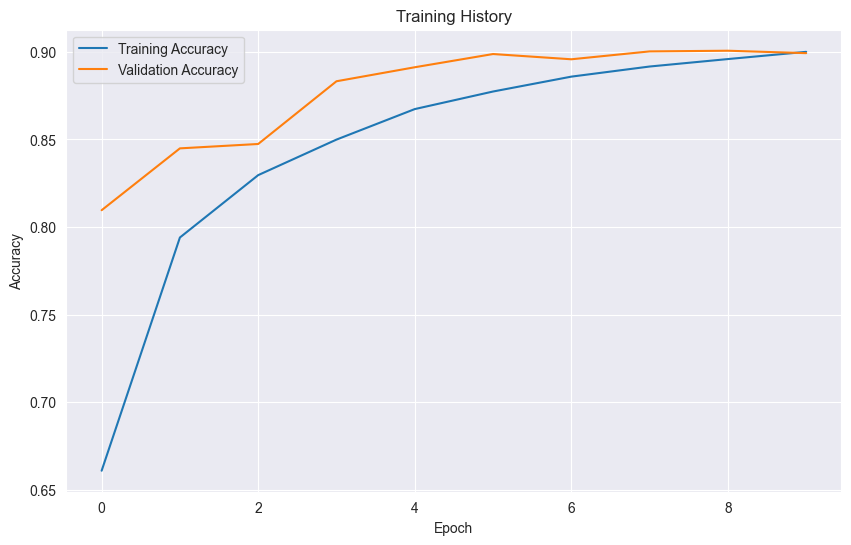

In [11]:
# Visualize the training history of the basic model
def plot_training_history(hist):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training History')
    plt.show()

plot_training_history(history)

---
## Optimization

In [26]:
def build_model(hp):
    this_model = models.Sequential([
        Input(shape=(256, 256, 3)),
        layers.Conv2D(4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (4, 4), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (4, 4), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(hp.Choice('dense1_units', [32, 64, 128]), activation='relu'),
        layers.Dropout(hp.Float('dropout1_rate', min_value=0.1, max_value=0.5, step=0.1)),
        layers.Dense(hp.Choice('dense2_units', [64, 128]), activation='relu'),
        layers.Dropout(hp.Float('dropout2_rate', min_value=0.1, max_value=0.5, step=0.1)),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(6, activation='softmax')
    ])
    
    this_model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                       loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'])

    return this_model


In [27]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    num_initial_points=2,
    seed=42,
    directory='../data/tuner_results',
    project_name='task_1_CNN_bayesian',
)

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense1_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout1_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense2_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout2_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [35]:
tuner.search(train_class_ds,
             epochs=5,
             validation_data=val_class_ds)

In [36]:
tuned_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [6]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 8)       296       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        1168      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [37]:
# Evaluate the best model
tuned_test_loss, tuned_test_accuracy = tuned_model.evaluate(test_class_ds)
print(f'Tuned Model Test Loss: {tuned_test_loss:.4f}')
print(f'Tuned Model Test Accuracy: {tuned_test_accuracy:.4f}')

1127/1127 [==============================] - 23s 20ms/step - loss: 0.3930 - accuracy: 0.8663
Best Model Test Loss: 0.3930
Best Model Test Accuracy: 0.8663


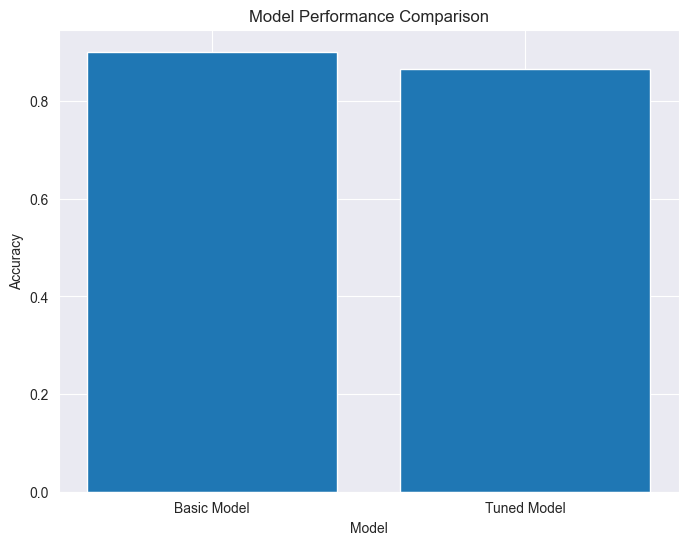

In [38]:
# Compare the performance of the basic model and the best model
model_labels = ['Basic Model', 'Tuned Model']
accuracies = [test_accuracy, tuned_test_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(model_labels, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.show()


---
## Model selection

In [39]:
best_model = None
if test_accuracy >= tuned_test_accuracy:
    best_model = basic_model
else:
    best_model = tuned_model

---
## Testing

1/1 [==============================] - 0s 25ms/step


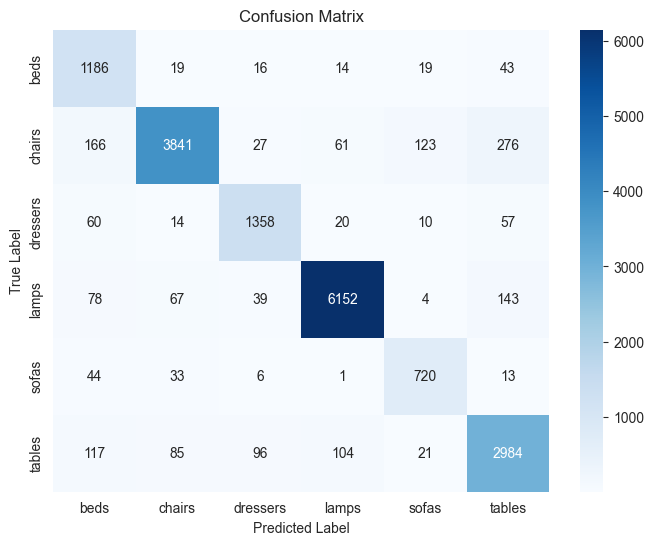

In [40]:
# Visualize the confusion matrix
def plot_confusion_matrix(model, test_data, label_encoder):
    y_true = []
    y_pred = []
    for images, labels in test_data:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    # Get the decoded class labels
    class_labels = label_encoder.inverse_transform(np.unique(y_true))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(best_model, test_class_ds, class_encoder)

1/1 [==============================] - 0s 33ms/step


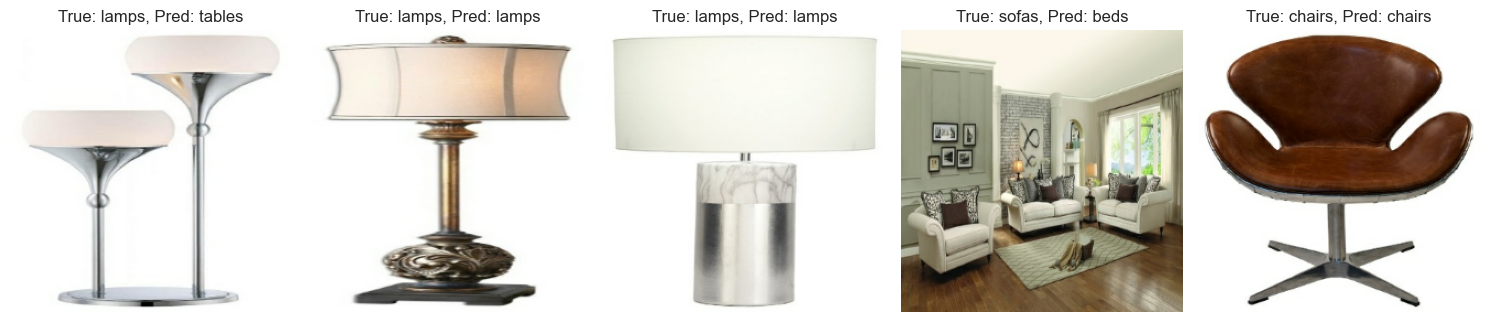

In [42]:
def visualize_predictions(model, test_data, label_encoder, num_samples=5):
    for images, labels in test_data.take(1):
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 12))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow((images[i].numpy() * 255).astype('uint8'))
            true_label = label_encoder.inverse_transform([labels[i]])[0]
            pred_label = label_encoder.inverse_transform([predicted_labels[i]])[0]
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

visualize_predictions(best_model, test_class_ds, class_encoder)

---
## Save model

In [43]:
from pathlib import Path

# Create paths
model_path = '../data/models'
processed_model_dir = Path(model_path)
processed_model_dir.mkdir(parents=True, exist_ok=True)

best_model.save(model_path + '/' + 'task-1-CNN.keras')

In [44]:
encoder_path = '../data/label_encoders'
label_encoder_dir = Path(encoder_path)
label_encoder_dir.mkdir(parents=True, exist_ok=True)

np.save(encoder_path + "/" + 'class_encoder.npy', class_encoder.classes_)